# Deep Structured Semantic Models (DSSM)

## Introduction

Deep Structured Semantic Models (DSSM) represent a class of neural network models designed for learning semantic representations of text data. These models have found applications in various natural language processing (NLP) tasks, with one notable application being web search using clickthrough data. The DSSM architecture aims to capture the semantic relationships between queries and documents, improving the relevance and accuracy of search results.

## Key Components

The DSSM architecture typically consists of the following key components:

1. **User Tower Module:**
   - Responsible for training user features.
   - Learns embeddings representing user behavior or preferences, often derived from clickthrough data.

2. **Item Tower Module:**
   - Responsible for training item features.
   - Learns embeddings representing document or item content.

3. **Temperature Factor:**
   - A hyperparameter influencing the similarity score between user and item embeddings.
   - Can be adjusted to control the smoothness of the similarity function.

4. **User and Item Parameters:**
   - Configurable parameters for the respective tower modules.
   - Include dimensions, activation functions, dropout rates, and options for output layers.

## Model Architecture

The DSSM model architecture is designed to capture the semantic meaning of text data through neural network layers. The architecture often includes the following stages:

1. **Embedding Layer:**
   - Converts input text data into dense vector representations.
   - Incorporates features from both user and item perspectives.

2. **User Tower:**
   - Processes user-specific features through a multilayer perceptron (MLP).
   - Normalizes the resulting embeddings to capture semantic information.

3. **Item Tower:**
   - Processes item-specific features through a separate MLP.
   - Normalizes the item embeddings for semantic understanding.

4. **Similarity Calculation:**
   - Computes the similarity score between the user and item embeddings.
   - The temperature factor influences the smoothness of the similarity function.

5. **Sigmoid Activation:**
   - Applies a sigmoid activation function to generate a probability-like output.
   - The final output represents the likelihood of a user-item pair being relevant.


In [29]:
import pandas as pd
import numpy as np

In [30]:
movies = pd.read_csv('datasets/ml-1m/movies.dat', sep='::', header=None, names=['movie_id','title', 'genres'], engine='python', encoding='latin-1')
ratings = pd.read_csv('datasets/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python', encoding='latin-1')
users = pd.read_csv('datasets/ml-1m/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip'], engine='python', encoding='latin-1')

In [31]:
print(ratings.head())
print(ratings.shape)
print(users.head())
print(movies.head())

   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
(1000209, 4)
   user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [32]:
data = pd.merge(pd.merge(ratings, users, on='user_id'), movies, on='movie_id')

# Display the result
print(data.head())
print(data.shape)

   user_id  movie_id  rating  timestamp gender  age  occupation    zip  \
0        1      1193       5  978300760      F    1          10  48067   
1        2      1193       5  978298413      M   56          16  70072   
2       12      1193       4  978220179      M   25          12  32793   
3       15      1193       4  978199279      M   25           7  22903   
4       17      1193       5  978158471      M   50           1  95350   

                                    title genres  
0  One Flew Over the Cuckoo's Nest (1975)  Drama  
1  One Flew Over the Cuckoo's Nest (1975)  Drama  
2  One Flew Over the Cuckoo's Nest (1975)  Drama  
3  One Flew Over the Cuckoo's Nest (1975)  Drama  
4  One Flew Over the Cuckoo's Nest (1975)  Drama  
(1000209, 10)


In [33]:
data.to_csv('./saved/full_data.csv', index=False)

In [34]:
# Use join to merge the DataFrames
data = ratings.join(users.set_index('user_id'), on='user_id').join(movies.set_index('movie_id'), on='movie_id')

In [35]:
data["cat_id"] = data["genres"].apply(lambda x: x.split("|")[0])
user_col, item_col = "user_id", "movie_id"
sparse_features = ['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip', "cat_id"]

In [36]:
from sklearn.preprocessing import LabelEncoder
import os

save_dir = './saved/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print(f'Before encoding: \n {data[sparse_features].tail()}')

feature_max_idx = {}
for feature in sparse_features:
    encoder = LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature]) + 1 # лучше энкодить не с 0, особенно в sequential NN
    feature_max_idx[feature] = data[feature].max() + 1
    if feature == user_col:
        user_map = {encode_id + 1: raw_id for encode_id, raw_id in enumerate(encoder.classes_)}
    if feature == item_col:
        item_map = {encode_id + 1: raw_id for encode_id, raw_id in enumerate(encoder.classes_)}
np.save(save_dir + "raw_id_maps.npy", (user_map, item_map))
np.save(save_dir + "feature_max_idx.npy", feature_max_idx)

print(f'\nAfter encoding: \n {data[sparse_features].tail()}')

Before encoding: 
          user_id  movie_id gender  age  occupation    zip      cat_id
1000204     6040      1091      M   25           6  11106      Comedy
1000205     6040      1094      M   25           6  11106       Drama
1000206     6040       562      M   25           6  11106      Comedy
1000207     6040      1096      M   25           6  11106       Drama
1000208     6040      1097      M   25           6  11106  Children's

After encoding: 
          user_id  movie_id  gender  age  occupation  zip  cat_id
1000204     6040      1020       2    3           7  467       5
1000205     6040      1023       2    3           7  467       8
1000206     6040       549       2    3           7  467       5
1000207     6040      1025       2    3           7  467       8
1000208     6040      1026       2    3           7  467       4


In [37]:
data.to_csv('./saved/data.csv', index=False)

In [38]:
import pandas as pd
import numpy as np

user_col, item_col = "user_id", "movie_id"
sparse_features = ['user_id', 'movie_id', 'gender', 'age', 'occupation', 'zip', "cat_id"]
data = pd.read_csv('./saved/data.csv', nrows=10000)
feature_max_idx = np.load('./saved/feature_max_idx.npy', allow_pickle=True).item()

In [39]:
from src.dssm.match import generate_seq_feature_match


df_train, df_test = generate_seq_feature_match(data,
                                               user_col,
                                               item_col,
                                               time_col="timestamp",
                                               item_attribute_cols=[],
                                               sample_method=2,
                                               mode=0,
                                               neg_ratio=5,
                                               min_item=15)

generate sequence features: 100%|██████████| 70/70 [00:00<00:00, 559.21it/s]


n_train: 59088, n_test: 69
1 cold start users droped 


In [40]:
train_set = set(df_train[(df_train['user_id'] == 1) & (df_train['label'] == 1)]['movie_id'].unique())
gt_set = set(data[data['user_id'] == 1]['movie_id'].unique())
# Check if all items from train_set are in gt_set
all_items_in_gt_set = train_set.issubset(gt_set)

print(f"All items from train_set are in gt_set: {all_items_in_gt_set}")

All items from train_set are in gt_set: True


In [41]:
user_cols = ["user_id", "gender", "age", "occupation", "zip"]
item_cols = ['movie_id', "cat_id"]
user_profile = data[user_cols].drop_duplicates('user_id')
item_profile = data[item_cols].drop_duplicates('movie_id')

In [42]:
from src.dssm.match import gen_model_input

x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_train = x_train["label"]
y_test = x_test["label"]

In [43]:
{k: v[:4] for k, v in x_train.items()}

{'user_id': array([10, 62, 29, 48]),
 'movie_id': array([1105, 2241,  977, 2137]),
 'hist_movie_id': array([[ 107, 1112,  575,  217,  853,  894, 1187, 2711, 2512, 1203, 1289,
         3623, 2822, 2786,  964, 3071, 3461,  576,  271, 2144, 2749, 2666,
          866, 2979, 2880, 3239, 1163, 2132, 3430, 1310, 1821,  145, 1546,
         1180, 2976, 3130, 1450, 2308,  757, 2657,  893,    1, 1178, 2872,
         3293, 2163, 1216, 1159,  355, 1013],
        [1208, 1202, 1133, 1168, 2014, 1789, 1019, 3193, 1211, 1086, 3310,
         1782, 2807, 1538, 1026, 1138, 1890, 3444, 2553, 1885, 1821, 1195,
         2056, 1779, 1297, 3028, 1889,  579, 2282, 3217, 1965, 2534, 3246,
         2894, 3600, 1966, 2099, 1967, 2551, 1752, 3082,  845,  860, 1755,
         2174,  581,  905, 2447,  894,  895],
        [1125, 2335, 1213, 1200, 1149, 1289, 2737, 1196,  576, 1133, 1107,
          444, 1774, 2666, 1131,  107, 3175, 1151, 2171, 3413, 1276, 1479,
         2741, 1775, 2709, 2848, 1121, 2742, 2744, 2889, 1

In [44]:
uid_35 = [2006, 1161,  844,  905,  594, 1173, 1178, 2558, 1261, 2375, 2960,
         1585, 1272, 2379,  852,  119,  310, 2937,  288, 2756, 1185, 1107,
         1141, 3131,   36, 2098, 1023,  755,   17, 1785, 1181, 1032, 3121,
         1564, 1317, 1776, 1778,  893, 3178, 2725, 2144, 2410, 2846, 1295,
         3509, 3095, 3331, 2973, 3587, 3330]
uid_35_gt = df_train[(df_train['user_id'] == 35) & (df_train['label'] == 1)]['movie_id'].unique()

np.isin(uid_35, uid_35_gt).all()

True

In [45]:
from src.dssm.layers import Feature
from src.dssm.model import DSSMModel

user_cols = ["user_id", "gender", "age"]
item_cols = ['movie_id', "cat_id"]

# Define Feature objects
user_features = [Feature(name=feature_name, vocab_dim=feature_max_idx[feature_name], embedding_dim=128, sequential=False, padding=None) for feature_name in user_cols]
item_features = [Feature(name=feature_name, vocab_dim=feature_max_idx[feature_name], embedding_dim=128, sequential=False, padding=None) for feature_name in item_cols]

hist_movie_id_feature = Feature(name='hist_movie_id', vocab_dim=feature_max_idx['movie_id'], embedding_dim=8, sequential=True, padding=0, shared_embedding='movie_id')
#user_features += [hist_movie_id_feature]
# Define MLP dimensions
mlp_dims = [16, 8, 4]

temperature = 0.5

# Create DSSMModel instance
model = DSSMModel(
    user_features=user_features,
    item_features=item_features,
    mlp_user_params={'dims': mlp_dims},
    mlp_item_params={'dims': mlp_dims},
    temperature=temperature
    )

In [46]:
model

DSSMModel(
  (feature_embeddings): FeatureEmbeddings(
    (embedding_layers): ModuleDict(
      (user_id): Embedding(6041, 128)
      (gender): Embedding(3, 128)
      (age): Embedding(8, 128)
      (movie_id): Embedding(3707, 128)
      (cat_id): Embedding(19, 128)
    )
  )
  (user_tower): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=384, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=16, out_features=8, bias=True)
      (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
      (8): Linear(in_features=8, out_features=4, bias=True)
      (9): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0, inplace=False)
    )
  )
  (item_tower): MLP(
    (mlp): Sequentia

In [47]:
model._calculate_input_dims(model.user_features)

384

In [48]:
model._calculate_input_dims(model.item_features)

256

In [49]:
# Example input data
import torch

data = {'user_id': torch.tensor([34, 17, 44]),
        'movie_id': torch.tensor([516, 409, 2027]),
        'hist_movie_id': torch.tensor([[653, 38, 2038, 1060, 670, 690, 644, 674, 481, 1121, 1726,
                                        647, 152, 700, 748, 720, 609, 668, 2065, 365, 897, 1570,
                                        693, 485, 1739, 472, 774, 477, 793, 799, 663, 276, 1076,
                                        649, 686, 63, 1065, 6, 729, 1618, 515, 1077, 688, 474,
                                        656, 437, 708, 355, 0, 0],
                                        [358, 1150, 220, 726, 119, 483, 359, 1155, 1162, 553, 558,
                                        564, 336, 1151, 562, 385, 353, 1148, 559, 867, 561, 577,
                                        141, 1536, 522, 935, 790, 595, 426, 470, 839, 560, 1111,
                                        442, 1156, 1994, 970, 37, 974, 1997, 703, 793, 1315, 2033,
                                        722, 1095, 757, 1936, 433, 0],
                                        [1894, 557, 945, 1802, 1372, 600, 1362, 146, 1257, 734, 1446,
                                        1203, 1136, 33, 2056, 1746, 1752, 570, 1285, 682, 678, 1,
                                        1671, 1742, 799, 722, 1309, 1342, 1873, 484, 1306, 1999, 729,
                                        1150, 1138, 587, 1619, 558, 823, 751, 1516, 584, 1015, 843,
                                        1341, 1616, 848, 1096, 1171, 909]]),
        'histlen_movie_id': torch.tensor([109, 396, 176]),
        'label': torch.tensor([0, 1, 0]),
        'gender': torch.tensor([2, 2, 1]),
        'age': torch.tensor([4, 3, 3]),
        'occupation': torch.tensor([8, 1, 3]),
        'zip': torch.tensor([29, 42, 39]),
        'cat_id': torch.tensor([8, 5, 8])}

pred = model(data)
print(pred)

tensor([0.5000, 0.6355, 0.6623], grad_fn=<SigmoidBackward0>)


In [50]:
from src.dssm.utils import df_to_dict
from src.dssm.utils import MatchDataGenerator

all_item = df_to_dict(item_profile)
test_user = x_test
data_generator = MatchDataGenerator(x=x_train, y=y_train)
train_dl, test_dl, item_dl = data_generator.generate_dataloader(test_user, all_item, batch_size=128)

In [51]:
from src.dssm.trainer import MatchTrainer

save_dir = './saved/'

trainer = MatchTrainer(model,
                       mode=0,
                       optimizer_params={
                           "lr": 1e-3,
                           "weight_decay": 1e-5
                       },
                       n_epoch=5,
                       device='cpu',
                       model_path=save_dir)


trainer.fit(train_dl)

epoch: 0


train:   0%|          | 0/462 [00:00<?, ?it/s, loss=1.02]

train: 100%|██████████| 462/462 [00:06<00:00, 75.92it/s, loss=0.734]


epoch: 1


train: 100%|██████████| 462/462 [00:05<00:00, 77.34it/s, loss=0.703]


epoch: 2


train: 100%|██████████| 462/462 [00:06<00:00, 75.46it/s, loss=0.694]


epoch: 3


train: 100%|██████████| 462/462 [00:06<00:00, 73.23it/s, loss=0.693]


epoch: 4


train: 100%|██████████| 462/462 [00:06<00:00, 72.61it/s, loss=0.693]


### Cosine similarity with temperature.

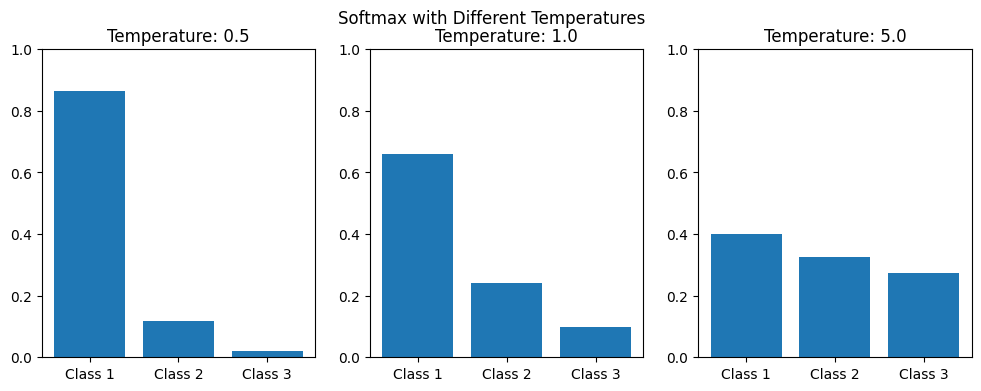

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, temperature=1.0):
    e_x = np.exp(x / temperature)
    return e_x / e_x.sum()

# Example usage
logits = np.array([2.0, 1.0, 0.1])

# Vary the temperature parameter to observe its effect
temperatures = [0.5, 1.0, 5.0]

# Plotting
plt.figure(figsize=(12, 4))

for i, temp in enumerate(temperatures):
    probabilities = softmax(logits, temperature=temp)
    
    plt.subplot(1, len(temperatures), i+1)
    plt.bar(range(len(probabilities)), probabilities, tick_label=['Class 1', 'Class 2', 'Class 3'])
    plt.title(f"Temperature: {temp}")
    plt.ylim([0, 1])

plt.suptitle('Softmax with Different Temperatures')
plt.show()



[0.2879814  0.69632838 0.01569022]
[0.36338114 0.4335631  0.20305575]
[0.35671505 0.40128049 0.24200446]
[0.33511184 0.33748725 0.32740091]


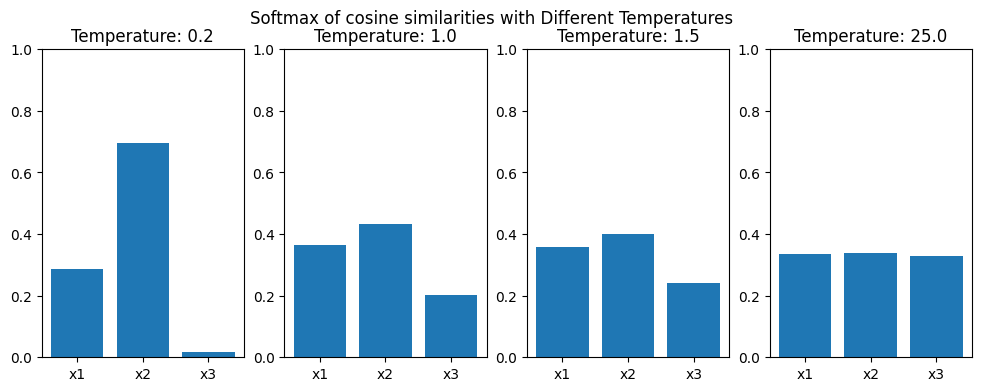

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_similarity(x, y, temperature=1.0):
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    
    similarity = dot_product / (norm_x * norm_y)
    scaled_similarity = similarity / temperature
    return scaled_similarity

def softmax(x, temperature=1.0):
    e_x = np.exp(x / temperature)
    return e_x / e_x.sum()

# Example usage
vector1 = np.array([1.0, 2.0, 3.0])
vector2 = np.array([3.0, 2.0, 1.0])
vector3 = np.array([2.0, 1.0, 2.0])
vector4 = np.array([50.0, -5.0, -5.0])

# Vary the temperature parameter to observe its effect
temperatures = np.array([0.2, 1.0, 1.5, 25])

# Plotting
plt.figure(figsize=(12, 4))

for i, temp in enumerate(temperatures):
    similarities1 = cosine_similarity(vector1, vector2, temperature=temp)
    similarities2 = cosine_similarity(vector1, vector3, temperature=temp)
    similarities3 = cosine_similarity(vector1, vector4, temperature=temp)
    sim = np.array([similarities1, similarities2, similarities3])
    softmax_probs = softmax(sim, temperature=1)
    print(softmax_probs)

    plt.subplot(1, len(temperatures), i+1)
    plt.bar([0, 1, 2], [softmax_probs[0], softmax_probs[1], softmax_probs[2]], tick_label=['x1', 'x2', 'x3'])
    plt.title(f"Temperature: {temp}")
    plt.ylim([0, 1])

plt.suptitle('Softmax of cosine similarities with Different Temperatures')
plt.show()

